!["County Warning Areas"](https://upload.wikimedia.org/wikipedia/commons/thumb/0/05/NWS_Weather_Forecast_Offices.svg/480px-NWS_Weather_Forecast_Offices.svg.png)

In [1]:
from __future__ import print_function
from awips.dataaccess import DataAccessLayer
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import numpy as np
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from cartopy.feature import ShapelyFeature,NaturalEarthFeature
from shapely.geometry import Polygon
from shapely.ops import cascaded_union

# Standard map plot
def make_map(bbox, projection=ccrs.PlateCarree()):
    fig, ax = plt.subplots(figsize=(12,12),
            subplot_kw=dict(projection=projection))
    ax.set_extent(bbox)
    ax.coastlines(resolution='50m')
    gl = ax.gridlines(draw_labels=True)
    gl.xlabels_top = gl.ylabels_right = False
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    return fig, ax

# Server, Data Request Type, and Database Table
DataAccessLayer.changeEDEXHost("edex-cloud.unidata.ucar.edu")
request = DataAccessLayer.newDataRequest('maps')
request.addIdentifier('table', 'mapdata.county')

Using 23 county MultiPolygons


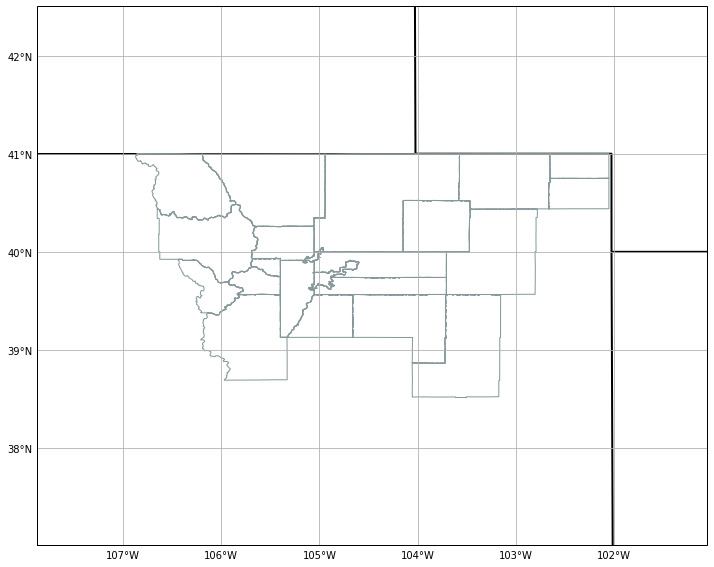

In [2]:

# Define a WFO ID for location
# tie this ID to the mapdata.county column "cwa" for filtering
request.setLocationNames('BOU')
request.addIdentifier('cwa', 'BOU')

# enable location filtering (inLocation)
# locationField is tied to the above cwa definition (BOU)
request.addIdentifier('geomField', 'the_geom')
request.addIdentifier('inLocation', 'true')
request.addIdentifier('locationField', 'cwa')

# This is essentially the same as "'"select count(*) from mapdata.cwa where cwa='BOU';" (=1)

# Get response and create dict of county geometries
response = DataAccessLayer.getGeometryData(request, [])
counties = np.array([])
for ob in response:
    counties = np.append(counties,ob.getGeometry())
print("Using " + str(len(counties)) + " county MultiPolygons")


%matplotlib inline
# All WFO counties merged to a single Polygon
merged_counties = cascaded_union(counties)
envelope = merged_counties.buffer(2)
boundaries=[merged_counties]

# Get bounds of this merged Polygon to use as buffered map extent
bounds = merged_counties.bounds
bbox=[bounds[0]-1,bounds[2]+1,bounds[1]-1.5,bounds[3]+1.5]


fig, ax = make_map(bbox=bbox)
# Plot political/state boundaries handled by Cartopy
political_boundaries = NaturalEarthFeature(category='cultural',
                               name='admin_0_boundary_lines_land',
                               scale='50m', facecolor='none')
states = NaturalEarthFeature(category='cultural',
                               name='admin_1_states_provinces_lines',
                               scale='50m', facecolor='none')
ax.add_feature(political_boundaries, linestyle='-', edgecolor='black')
ax.add_feature(states, linestyle='-', edgecolor='black',linewidth=2)

# Plot CWA counties
for i, geom in enumerate(counties):
    cbounds = Polygon(geom)
    intersection = cbounds.intersection
    geoms = (intersection(geom)
         for geom in counties
         if cbounds.intersects(geom))
    shape_feature = ShapelyFeature(geoms,ccrs.PlateCarree(), 
                        facecolor='none', linestyle="-",edgecolor='#86989B')
    ax.add_feature(shape_feature)

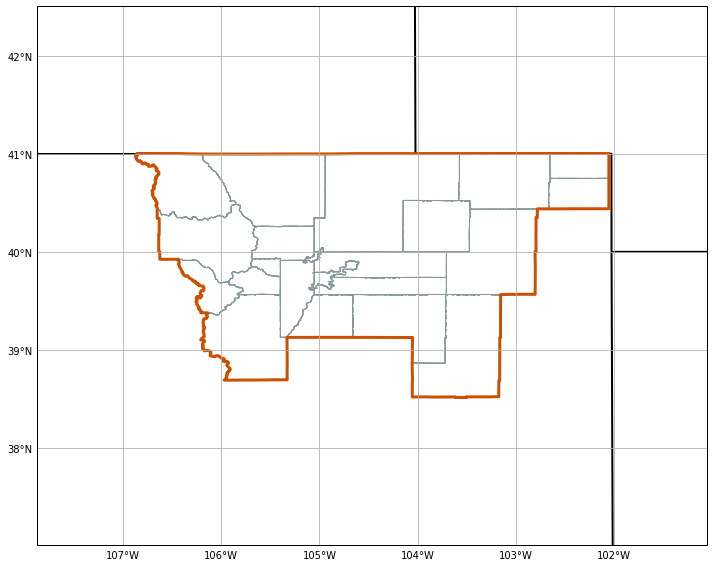

In [3]:
# Plot CWA envelope
for i, geom in enumerate(boundaries):
    gbounds = Polygon(geom)
    intersection = gbounds.intersection
    geoms = (intersection(geom)
         for geom in boundaries
         if gbounds.intersects(geom))
    shape_feature = ShapelyFeature(geoms,ccrs.PlateCarree(), 
                        facecolor='none', linestyle="-",linewidth=3.,edgecolor='#cc5000')
    ax.add_feature(shape_feature)

fig

In [4]:
request = DataAccessLayer.newDataRequest('maps', envelope=envelope)
request.addIdentifier('table', 'mapdata.city')
request.addIdentifier('geomField', 'the_geom')
request.setParameters('name','population','prog_disc')
cities = DataAccessLayer.getGeometryData(request, [])
print("Found " + str(len(cities)) + " city Points")


Found 1208 city Points


In [5]:
request.parameters

['name', 'population', 'prog_disc']

In [6]:
ob.getNumber("prog_disc"),ob.getString("population")

KeyError: b'prog_disc'

In [7]:
citylist = []
cityname = []
# For BOU, progressive disclosure values above 50 and pop above 5000 looks good
for ob in cities:
    
    #if ((ob.getNumber("prog_disc")>50) and int(ob.getString("population")) > 5000):
    if ((ob.getNumber("prog_disc")>7000)):
        print(ob.getNumber("prog_disc"))
        citylist.append(ob.getGeometry())
        cityname.append(ob.getString("name"))
"""
citylist.append(ob.getGeometry())
cityname.append(ob.getString("name"))
print("Using " + str(len(cityname)) + " city Points")

# Plot city markers
ax.scatter([point.x for point in citylist],
       [point.y for point in citylist],
       transform=ccrs.Geodetic(),marker="+",facecolor='black')
# Plot city names
for i, txt in enumerate(cityname):
    ax.annotate(txt, (citylist[i].x,citylist[i].y),
                xytext=(3,3), textcoords="offset points")

fig
"""
cityname

7400
7900
7500
7860
7200
7780
7360
7510


['McCook',
 'Goodland',
 'Colby',
 'Garden City',
 'Hugoton',
 'Liberal',
 'Scott City',
 'Ulysses']

In [35]:
citylist.append(ob.getGeometry())


In [8]:
cityname.append(ob.getString("name"))
print("Using " + str(len(cityname)) + " city Points")



Using 9 city Points


In [9]:

from geopy.geocoders import Nominatim

/Users/chowdahead/miniconda3/envs/py-awips/lib/python3.7/site-packages/ipykernel_launcher.py:40: DeprecationWarning: Using Nominatim with the default "geopy/1.20.0" `user_agent` is strongly discouraged, as it violates Nominatim's ToS https://operations.osmfoundation.org/policies/nominatim/ and may possibly cause 403 and 429 HTTP errors. Please specify a custom `user_agent` with `Nominatim(user_agent="my-application")` or by overriding the default `user_agent`: `geopy.geocoders.options.default_user_agent = "my-application"`. In geopy 2.0 this will become an exception.


McCook
Goodland
Colby
Garden City
Hugoton
Liberal
Scott City
Ulysses
Thomson Causeway


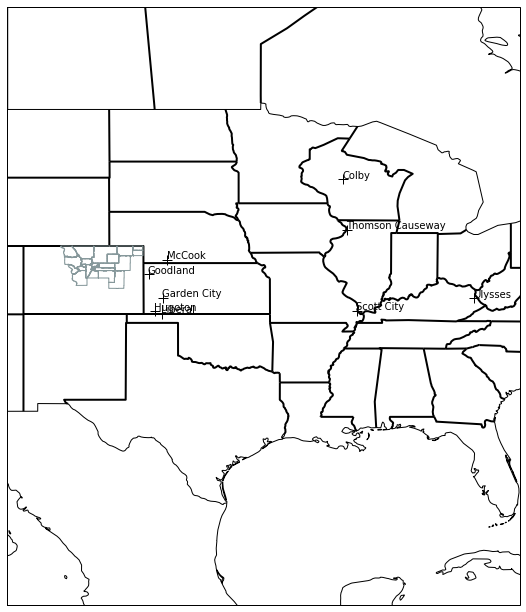

In [10]:
# Create new figure
fig = plt.figure(figsize=(17., 11.))

#add_metpy_logo(fig, 30, 1000, size='small')

    # Add the map and set the extent
ax = plt.subplot(111, projection=ccrs.PlateCarree())
ax.coastlines(resolution='50m')
# Plot city markers
political_boundaries = NaturalEarthFeature(category='cultural',
                               name='admin_0_boundary_lines_land',
                               scale='50m', facecolor='none')
states = NaturalEarthFeature(category='cultural',
                               name='admin_1_states_provinces_lines',
                               scale='50m', facecolor='none')
ax.add_feature(political_boundaries, linestyle='-', edgecolor='black')
ax.add_feature(states, linestyle='-', edgecolor='black',linewidth=2)

# Plot CWA counties
for i, geom in enumerate(counties):
    cbounds = Polygon(geom)
    intersection = cbounds.intersection
    geoms = (intersection(geom)
         for geom in counties
         if cbounds.intersects(geom))
    shape_feature = ShapelyFeature(geoms,ccrs.PlateCarree(), 
                        facecolor='none', linestyle="-",edgecolor='#86989B')
    ax.add_feature(shape_feature)


#ax.scatter([point.x for point in citylist],
#       [point.y for point in citylist],
#       transform=ccrs.PlateCarree(),marker="+",facecolor='black')

# Plot city names
#for i, txt in enumerate(cityname):
#    ax.annotate(txt, (citylist[i].x,citylist[i].y),
#                xytext=(3,3), textcoords="offset points")

geolocator = Nominatim()
for city in cityname:
    print(city)
    loc = geolocator.geocode(city)
    #x, y = plt(loc.longitude, loc.latitude)
    ax.plot(loc.longitude, loc.latitude,marker='+',color='k',markersize=10)
    ax.text(loc.longitude-0.05, loc.latitude+0.05,city,color='k')#linewidth=4,

    
ax.set_extent([-110,-80,20,55],ccrs.PlateCarree())

Using 208 lake MultiPolygons


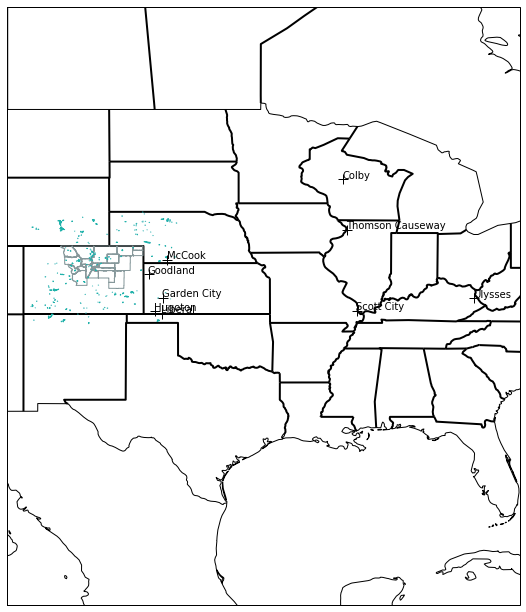

In [11]:
request = DataAccessLayer.newDataRequest('maps', envelope=envelope)
request.addIdentifier('table', 'mapdata.lake')
request.addIdentifier('geomField', 'the_geom')
request.setParameters('name')

# Get lake geometries
response = DataAccessLayer.getGeometryData(request, [])
lakes = np.array([])
for ob in response:
    lakes = np.append(lakes,ob.getGeometry())
print("Using " + str(len(lakes)) + " lake MultiPolygons")

# Plot lakes
for i, geom in enumerate(lakes):
    cbounds = Polygon(geom)
    intersection = cbounds.intersection
    geoms = (intersection(geom)
         for geom in lakes
         if cbounds.intersects(geom))
    shape_feature = ShapelyFeature(geoms,ccrs.PlateCarree(), 
                        facecolor='blue', linestyle="-",edgecolor='#20B2AA')
    ax.add_feature(shape_feature)
fig

In [ ]:
request = DataAccessLayer.newDataRequest('maps', envelope=envelope)
request.addIdentifier('table', 'mapdata.majorrivers')
request.addIdentifier('geomField', 'the_geom')
request.setParameters('pname')
rivers = DataAccessLayer.getGeometryData(request, [])
print("Using " + str(len(rivers)) + " river MultiLineStrings")
import cartopy.feature as cfeature
import cartopy.io.shapereader as shpreader
#reader = shpreader.Reader('/Users/chowdahead/Downloads/countyl010g_shp_nt00964/countyl010g.shp')
#counties = list(reader.geometries())
#COUNTIES = cfeat.ShapelyFeature(counties,ccrs.PlateCarree())
#ax.add_feature(COUNTIES, facecolor='none',edgecolor='r')

reader = shpreader.Reader('/Users/chowdahead/Downloads/tl_2016_us_primaryroads/tl_2016_us_primaryroads.shp')
counties = list(reader.geometries())
COUNTIES = cfeature.ShapelyFeature(counties,ccrs.PlateCarree())
ax.add_feature(COUNTIES, facecolor='none',edgecolor='g')
# Plot rivers
for ob in rivers:
    shape_feature = ShapelyFeature(ob.getGeometry(),ccrs.PlateCarree(), 
                        facecolor='none', linestyle=":",edgecolor='#20B2AA')
    ax.add_feature(shape_feature)
fig

In [ ]:
import numpy.ma as ma
request = DataAccessLayer.newDataRequest()
request.setDatatype("topo")
request.addIdentifier("group", "/")
request.addIdentifier("dataset", "full")
request.setEnvelope(envelope)
gridData = DataAccessLayer.getGridData(request)
print(gridData)
print("Number of grid records: " + str(len(gridData)))
print("Sample grid data shape:\n" + str(gridData[0].getRawData().shape) + "\n")
print("Sample grid data:\n" + str(gridData[0].getRawData()) + "\n")

In [ ]:
from geopy.geocoders import Nominatim
import math

cities = ["Colorado Springs",
          "Boulder",
          "Fort Collins",
         "Denver"] #"Pueblo"
bbox = [-130.,-60,10.,60.]
bbox=[-110,-90,30,45]

In [ ]:

#fig, ax = make_map(bbox=bbox)
grid=gridData[0]
topo=ma.masked_invalid(grid.getRawData()) 
lons, lats = grid.getLatLonCoords()
print(topo.min())
print(topo.max())

# Plot topography
cs = ax.contourf(lons, lats, topo, 80, cmap=plt.get_cmap('terrain'),alpha=0.1)
#cbar = fig.colorbar(cs, extend='both', shrink=0.5, orientation='horizontal')
#cbar.set_label("topography height in meters")

geolocator = Nominatim()
for city in cities:
    print(city)
    loc = geolocator.geocode(city)
    #x, y = plt(loc.longitude, loc.latitude)
    ax.plot(loc.longitude, loc.latitude,marker='+',color='k',markersize=10)
    ax.text(loc.longitude-0.05, loc.latitude+0.05,city,color='k')#linewidth=4,

fig
fig.savefig("/Users/chowdahead/Desktop/AWIPS_CO_cwa.png",bbox_inches="tight")

# Satellite

In [ ]:
%matplotlib inline
from awips.dataaccess import DataAccessLayer
import cartopy.crs as ccrs
import cartopy.feature as cfeat
import matplotlib.pyplot as plt
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import numpy as np
import datetime



In [ ]:
DataAccessLayer.changeEDEXHost("edex-cloud.unidata.ucar.edu")
request = DataAccessLayer.newDataRequest()
request.setDatatype("satellite")

In [ ]:
availableSectors = DataAccessLayer.getAvailableLocationNames(request)
availableSectors.sort()

print("\nAvailable sectors and products\n")
for sect in availableSectors:
    request.setLocationNames(sect)
    availableProducts = DataAccessLayer.getAvailableParameters(request)
    availableProducts.sort()
    print(sect + ":")
    for prod in availableProducts:
        print("  - "+prod)


In [ ]:
request.setLocationNames("EMESO-2")
availableProducts = DataAccessLayer.getAvailableParameters(request)
availableProducts.sort()




In [ ]:
list(availableProducts)

In [ ]:
request.setParameters(availableProducts[15])

In [ ]:
utc = datetime.datetime.utcnow()
times = DataAccessLayer.getAvailableTimes(request)
hourdiff = utc - datetime.datetime.strptime(str(times[-1]),'%Y-%m-%d %H:%M:%S')
hours,days = hourdiff.seconds/3600,hourdiff.days
minute = str((hourdiff.seconds - (3600 * hours)) / 60)
offsetStr = ''
if hours > 0:
    offsetStr += str(hours) + "hr "
offsetStr += str(minute) + "m ago"
if days > 1:
    offsetStr = str(days) + " days ago"

print("Found "+ str(len(times)) +" available times")
print("  "+str(times[0]) + "\n    to\n  " + str(times[-1]))
print("Using "+str(times[-1]) + " ("+offsetStr+")")

In [ ]:
response = DataAccessLayer.getGridData(request, [times[-1]])
grid = response[0]
data = grid.getRawData()
data = np.ma.masked_where(data<10,data)
lons,lats = grid.getLatLonCoords()
bbox = [lons.min(), lons.max(), lats.min(), lats.max()]
bbox = [-130.,-60,10.,60.]
bbox = [-110.,-90,30.,45.]
print("grid size " + str(data.shape))
print("grid extent " + str(list(bbox)))

In [ ]:
#lats.replace(np.nan, 0)
lats = np.nan_to_num(lats)
lons = np.nan_to_num(lons)

In [ ]:
import GOES_IR_ColorMap as IR

In [ ]:
IR.IR_Colormap()

In [ ]:
def make_map(bbox, projection=ccrs.PlateCarree()):
    fig, ax = plt.subplots(figsize=(18,14),
            subplot_kw=dict(projection=projection))
    ax.set_extent(bbox)
    ax.coastlines(resolution='50m')
    gl = ax.gridlines(draw_labels=True,linestyle='--')
    gl.xlabels_top = gl.ylabels_right = False
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    return fig, ax

fig, ax = make_map(bbox=bbox)
# State boundaries
#states = cfeat.NaturalEarthFeature(category='cultural',
#                                    name='admin_1_states_provinces_lines',
#                                    scale='50m', facecolor='none')
state_borders = cfeat.NaturalEarthFeature(
                category='cultural', name='admin_1_states_provinces_lines',
                scale='50m', facecolor='none')
ax.add_feature(state_borders, edgecolor='b', linewidth=1, zorder=3)
country_borders = cfeat.NaturalEarthFeature(category='cultural',
            name='admin_0_countries',scale='50m', facecolor='none')

import cartopy.feature as cfeature
import cartopy.io.shapereader as shpreader
#reader = shpreader.Reader('/Users/chowdahead/Downloads/countyl010g_shp_nt00964/countyl010g.shp')
#counties = list(reader.geometries())
#COUNTIES = cfeat.ShapelyFeature(counties,ccrs.PlateCarree())
#ax.add_feature(COUNTIES, facecolor='none',edgecolor='r')

reader = shpreader.Reader('/Users/chowdahead/Downloads/tl_2016_us_primaryroads/tl_2016_us_primaryroads.shp')
counties = list(reader.geometries())
COUNTIES = cfeat.ShapelyFeature(counties,ccrs.PlateCarree())
ax.add_feature(COUNTIES, facecolor='none',edgecolor='r')

ax.add_feature(country_borders,edgecolor='b',linewidth=1)
#ax.add_feature(states, linestyle='-',color='r')


cs = ax.pcolormesh(lons, lats, data, cmap=IR.IR_Colormap(),vmin=162.,vmax=330.)
cbar = fig.colorbar(cs, shrink=0.9, orientation='horizontal')
cbar.set_label(str(grid.getLocationName())+" " \
               +str(grid.getParameter())+" " \
               +str(grid.getDataTime().getRefTime()))
#plt.tight_layout()


In [ ]:
# Draw the locations of cities on a map of the US

import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
from geopy.geocoders import Nominatim
import math

cities = [["Chicago",10],
          ["Boston",10],
          ["New York",5],
          ["San Francisco",25]]
scale = 5

map = Basemap(llcrnrlon=-119,llcrnrlat=22,urcrnrlon=-64,urcrnrlat=49,
        projection='lcc',lat_1=32,lat_2=45,lon_0=-95)

# load the shapefile, use the name 'states'
map.readshapefile('st99_d00', name='states', drawbounds=True)

# Get the location of each city and plot it
geolocator = Nominatim()
for (city,count) in cities:
    loc = geolocator.geocode(city)
    x, y = plt(loc.longitude, loc.latitude)
    plt(x,y,marker='o',color='Red',markersize=int(math.sqrt(count))*scale)
plt.show()

In [ ]:
# Standard map plot
def make_map(bbox, projection=ccrs.PlateCarree()):
    fig, ax = plt.subplots(figsize=(12,12),
            subplot_kw=dict(projection=projection))
    ax.set_extent(bbox)
    ax.coastlines(resolution='50m')
    gl = ax.gridlines(draw_labels=True)
    gl.xlabels_top = gl.ylabels_right = False
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    return fig, ax


In [ ]:
bbox = [-110.,-90,30.,45.]
import cartopy.feature as cfeature
import cartopy.io.shapereader as shpreader

In [ ]:
fig, ax = make_map(bbox=bbox)
# State boundaries
#states = cfeat.NaturalEarthFeature(category='cultural',
#                                    name='admin_1_states_provinces_lines',
#                                    scale='50m', facecolor='none')
state_borders = cfeature.NaturalEarthFeature(
                category='cultural', name='admin_1_states_provinces_lines',
                scale='50m', facecolor='none')
ax.add_feature(state_borders, edgecolor='b', linewidth=1, zorder=3)
country_borders = cfeature.NaturalEarthFeature(category='cultural',
            name='admin_0_countries',scale='50m', facecolor='none')
import matplotlib.pyplot as plt

from geopy.geocoders import Nominatim
import math

cities = [["Colorado Springs",10],
          ["Boulder",10],
          ["Fort Collins",5],
          ["Pueblo",25],
         ["Denver",10]]
scale = 5


# load the shapefile, use the name 'states'
#map.readshapefile('st99_d00', name='states', drawbounds=True)
reader = shpreader.Reader('/Users/chowdahead/Downloads/tl_2016_us_primaryroads/tl_2016_us_primaryroads.shp')
counties = list(reader.geometries())
COUNTIES = cfeature.ShapelyFeature(counties,ccrs.PlateCarree())
ax.add_feature(COUNTIES, facecolor='none',edgecolor='r')



# Get the location of each city and plot it
geolocator = Nominatim()
for (city,count) in cities:
    loc = geolocator.geocode(city)
    #x, y = plt(loc.longitude, loc.latitude)
    ax.plot(loc.longitude, loc.latitude,marker='+',color='k',markersize=10) #linewidth=4,